### Running the code in a clean notebook

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_datareader as pdr

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from pykalman import KalmanFilter

data = pd.read_csv("backtesting_data.csv")

In [24]:
import sys
sys.path.append('/Users/Sella/Desktop/2024Spring/FinancialAnalytics/FinalProject/final')

import importlib
import functions
importlib.reload(functions)
from functions_update import *

In [25]:
LONG = -50000000
LOWERBOUND = -1
UPPERBOUND = 1
LOWERNORMAL = -0.9
UPPERNORMAL = 0.9
MIN_CONSECUTIVE_DAYS = 3


In [26]:
data

,date,FEZ Price,EWJ Price,Z-Score,long_size,long_etf
0,2002-10-22,12.568131,20.394314,-1.084152,5.420759e+07,EWJ
1,2002-10-23,12.250083,20.727160,-0.957287,4.786433e+07,NaN
2,2002-10-24,12.198788,20.394314,-1.012163,5.060816e+07,EWJ
3,2002-10-25,12.337286,20.848198,-0.950692,4.753459e+07,NaN
4,2002-10-28,12.527097,20.848198,-0.987688,4.938438e+07,NaN
...,...,...,...,...,...,...
5369,2024-02-22,50.344189,68.900002,1.007151,-5.035756e+07,FEZ
5370,2024-02-23,50.374134,69.010002,1.022755,-5.113773e+07,FEZ
5371,2024-02-26,50.434017,69.000000,1.009133,-5.045667e+07,FEZ
5372,2024-02-27,50.673565,69.180000,0.997527,-4.987635e+07,NaN


In [27]:
## Adding columns to the dataframe
data = data.copy()
data['long_size'] = data['Z-Score'] * LONG

# Long versus short
data['long_etf'] = np.where(
    (data['Z-Score'] > UPPERBOUND) & (data['Z-Score'] > 0), 'FEZ',
    np.where(
        (data['Z-Score'] < LOWERBOUND) & (data['Z-Score'] < 0), 'EWJ',
        np.nan
    )
)

In [28]:
processed_data = identify_trade_periods(data, UPPERBOUND, LOWERBOUND, UPPERNORMAL, LOWERNORMAL, MIN_CONSECUTIVE_DAYS)
processed_data.head()

,date,FEZ Price,EWJ Price,Z-Score,long_size,long_etf,execute_start_condition,execute_exit_condition,start_cumsum,exit_cumsum,start_count,exit_count,execute_start,execute_exit,in_trade
0,2002-10-22,12.568131,20.394314,-1.084152,5.420759e+07,EWJ,True,False,1,1,1,0,False,False,False
1,2002-10-23,12.250083,20.727160,-0.957287,4.786433e+07,nan,False,False,2,1,0,0,False,False,False
2,2002-10-24,12.198788,20.394314,-1.012163,5.060816e+07,EWJ,True,False,3,1,1,0,False,False,False
3,2002-10-25,12.337286,20.848198,-0.950692,4.753459e+07,nan,False,False,4,1,0,0,False,False,False
4,2002-10-28,12.527097,20.848198,-0.987688,4.938438e+07,nan,False,False,4,1,0,0,False,False,False


In [29]:
processed_data = processed_data.drop(columns=['execute_start_condition','execute_exit_condition','start_cumsum','exit_cumsum','start_count','exit_count','execute_start','execute_exit'])

In [30]:
if processed_data.iloc[-1]['in_trade']:
    processed_data.at[data.index[-1], 'in_trade'] = False
processed_data.head()

,date,FEZ Price,EWJ Price,Z-Score,long_size,long_etf,in_trade
0,2002-10-22,12.568131,20.394314,-1.084152,5.420759e+07,EWJ,False
1,2002-10-23,12.250083,20.727160,-0.957287,4.786433e+07,nan,False
2,2002-10-24,12.198788,20.394314,-1.012163,5.060816e+07,EWJ,False
3,2002-10-25,12.337286,20.848198,-0.950692,4.753459e+07,nan,False
4,2002-10-28,12.527097,20.848198,-0.987688,4.938438e+07,nan,False


In [31]:
processed_data = process_trading_periods(processed_data)
processed_data.head()

,date,FEZ Price,EWJ Price,Z-Score,long_size,long_etf,in_trade,hedge_ratio
0,2002-10-22,12.568131,20.394314,-1.084152,5.420759e+07,EWJ,False,NaN
1,2002-10-23,12.250083,20.727160,-0.957287,4.786433e+07,nan,False,NaN
2,2002-10-24,12.198788,20.394314,-1.012163,5.060816e+07,EWJ,False,NaN
3,2002-10-25,12.337286,20.848198,-0.950692,4.753459e+07,nan,False,NaN
4,2002-10-28,12.527097,20.848198,-0.987688,4.938438e+07,nan,False,NaN


In [32]:
processed_data = calculate_trade_pnl(processed_data, LONG)

In [33]:
processed_data.head()

,date,FEZ Price,EWJ Price,Z-Score,long_size,long_etf,in_trade,hedge_ratio,long_allocation,short_allocation,capital_layover,long_shares,short_shares,PnL_per_trade,daily_PnL_per_trade,prev_hedge_ratio
0,2002-10-22,12.568131,20.394314,-1.084152,5.420759e+07,EWJ,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579447
1,2002-10-23,12.250083,20.727160,-0.957287,4.786433e+07,nan,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579447
2,2002-10-24,12.198788,20.394314,-1.012163,5.060816e+07,EWJ,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579447
3,2002-10-25,12.337286,20.848198,-0.950692,4.753459e+07,nan,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579447
4,2002-10-28,12.527097,20.848198,-0.987688,4.938438e+07,nan,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.579447


In [34]:
processed_data.columns

Index(['date', 'FEZ Price', 'EWJ Price', 'Z-Score', 'long_size', 'long_etf',
       'in_trade', 'hedge_ratio', 'long_allocation', 'short_allocation',
       'capital_layover', 'long_shares', 'short_shares', 'PnL_per_trade',
       'daily_PnL_per_trade', 'prev_hedge_ratio'],
      dtype='object')

## Risk Part

In [35]:
result_df = processed_data[processed_data['capital_layover']!=0].reset_index(drop=True)
result_df.head()

,date,FEZ Price,EWJ Price,Z-Score,long_size,long_etf,in_trade,hedge_ratio,long_allocation,short_allocation,capital_layover,long_shares,short_shares,PnL_per_trade,daily_PnL_per_trade,prev_hedge_ratio
0,2002-11-13,12.598918,20.696911,-1.031173,5.155867e+07,EWJ,True,0.579447,5.155867e+07,-2.987552e+07,2.168315e+07,2.491129e+06,-2.371277e+06,2.366013e+06,5.257807e+04,0.579447
1,2003-03-19,11.937159,19.547073,-1.126304,5.631521e+07,EWJ,True,0.579594,5.631521e+07,-3.071443e+07,2.560078e+07,2.881005e+06,-2.573010e+06,1.926273e+07,2.638731e+05,0.545402
2,2003-08-05,14.818493,22.330868,-1.145316,5.726579e+07,EWJ,True,0.633981,5.726579e+07,-3.464914e+07,2.261665e+07,2.564423e+06,-2.338236e+06,5.515185e+06,6.127983e+05,0.605058
3,2006-01-13,24.262630,42.939846,1.030814,-5.154068e+07,FEZ,True,0.551892,-5.154068e+07,2.864065e+07,-2.290003e+07,-2.124283e+06,6.669948e+05,1.214775e+06,1.214775e+06,0.555690
4,2006-04-05,26.202213,44.893036,1.033466,-5.167329e+07,FEZ,True,0.570670,-5.167329e+07,2.980644e+07,-2.186685e+07,-1.972096e+06,6.639435e+05,2.400013e+06,7.500040e+04,0.576825


In [36]:
risk_metrics = calculate_risk_metrics(result_df)
risk_metrics

{'Total Return': 10740677.860899393,
 'Average Return per Trade': 370368.20209997904,
 'Average Return Rate': 0.4338861437516289,
 'Sharpe Ratio': 6.085035276718504,
 'Maximum Drawdown': -62116497.24303675,
 'Win Rate': 0.6896551724137931,
 'Average Win': 5952142.593266713,
 'Average Loss': -12033574.889381655,
 'VaR (95%)': -299079.2589199579,
 'CVaR (95%)': -303543.45444171526}

## Incorporating Macro Factors

In [37]:
# Before we do this, we should plot the data to see our total returns over time.
result_df

,date,FEZ Price,EWJ Price,Z-Score,long_size,long_etf,in_trade,hedge_ratio,long_allocation,short_allocation,capital_layover,long_shares,short_shares,PnL_per_trade,daily_PnL_per_trade,prev_hedge_ratio
0,2002-11-13,12.598918,20.696911,-1.031173,5.155867e+07,EWJ,True,0.579447,5.155867e+07,-2.987552e+07,2.168315e+07,2.491129e+06,-2.371277e+06,2.366013e+06,5.257807e+04,0.579447
1,2003-03-19,11.937159,19.547073,-1.126304,5.631521e+07,EWJ,True,0.579594,5.631521e+07,-3.071443e+07,2.560078e+07,2.881005e+06,-2.573010e+06,1.926273e+07,2.638731e+05,0.545402
2,2003-08-05,14.818493,22.330868,-1.145316,5.726579e+07,EWJ,True,0.633981,5.726579e+07,-3.464914e+07,2.261665e+07,2.564423e+06,-2.338236e+06,5.515185e+06,6.127983e+05,0.605058
3,2006-01-13,24.262630,42.939846,1.030814,-5.154068e+07,FEZ,True,0.551892,-5.154068e+07,2.864065e+07,-2.290003e+07,-2.124283e+06,6.669948e+05,1.214775e+06,1.214775e+06,0.555690
4,2006-04-05,26.202213,44.893036,1.033466,-5.167329e+07,FEZ,True,0.570670,-5.167329e+07,2.980644e+07,-2.186685e+07,-1.972096e+06,6.639435e+05,2.400013e+06,7.500040e+04,0.576825
5,2007-09-13,34.083221,41.616642,-1.141214,5.706069e+07,EWJ,True,0.799323,5.706069e+07,-4.445043e+07,1.261025e+07,1.371103e+06,-1.304173e+06,-3.925552e+07,-1.396994e+05,0.779003
6,2008-10-28,19.135368,27.303818,-1.017441,5.087204e+07,EWJ,True,0.675227,5.087204e+07,-3.364696e+07,1.722508e+07,1.863184e+06,-1.758365e+06,5.763089e+06,9.605149e+05,0.661404
7,2008-12-11,19.784023,27.834282,-1.040477,5.202386e+07,EWJ,True,0.685304,5.202386e+07,-3.463469e+07,1.738917e+07,1.869057e+06,-1.750639e+06,3.040895e+06,2.764450e+05,0.665746
8,2009-02-23,15.043630,22.968071,-1.065000,5.325001e+07,EWJ,True,0.626562,5.325001e+07,-3.412247e+07,1.912754e+07,2.318436e+06,-2.268234e+06,1.126080e+07,4.691999e+05,0.640797
9,2009-05-01,19.218529,27.184122,-1.056979,5.284896e+07,EWJ,True,0.681035,5.284896e+07,-3.486128e+07,1.798768e+07,1.944112e+06,-1.813941e+06,3.334112e+06,3.334112e+05,0.659640


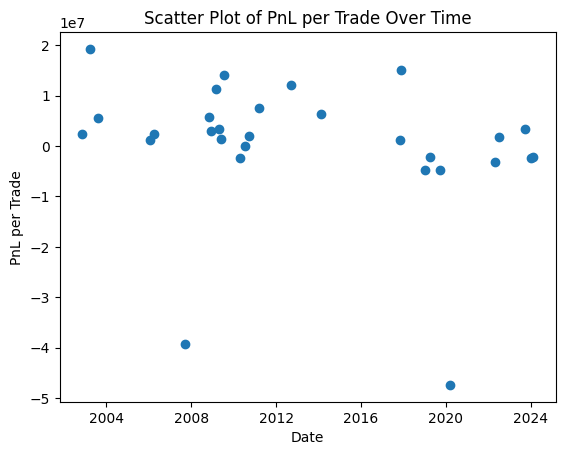

In [38]:
result_df['date'] = pd.to_datetime(result_df['date'])
plt.scatter(result_df.set_index('date').index, result_df['PnL_per_trade'])
plt.xlabel('Date')
plt.ylabel('PnL per Trade')
plt.title('Scatter Plot of PnL per Trade Over Time')
plt.show()

In [17]:
# This trade would be much better to run where there aren't huge macro events affecting the market. 2020 and 2008/2009 were both times when the market crashed.
# Thus, a macro factor we would consider is the day-over-day drop in EWJ and FEZ. If the day over day drop is too large, then we shouldn't run the trade
# The logic: when there is too large of a day over day drop, there are likely factors at play in the market that impact the trade in unforeseen ways
# In addition, in those periods of extreme market turbulence, there are likely other trades to be made that are better bets; thus, the opportunity cost of running this trade would be too high to make it worth running